In [1]:
import matplotlib.pyplot as plt
%matplotlib inline 

import numpy as np
import matplotlib.patches as patches

In [3]:
import keras
from keras.models import Sequential
from keras.optimizers import SGD, adam
from keras.utils import np_utils
#import layers
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping

import sys

# Define functions

In [4]:
def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

In [5]:
def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

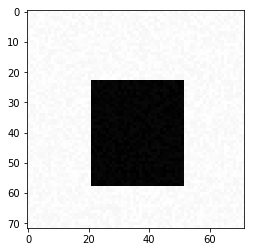

In [6]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(72,72), cmap='gray')

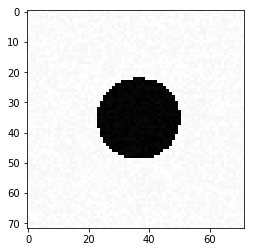

In [7]:
im = generate_a_disk(10)
plt.imshow(im.reshape(72,72), cmap='gray')

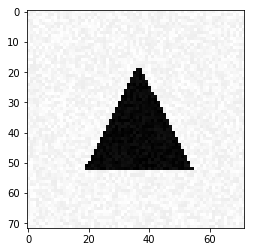

In [8]:
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(72,72), cmap='gray')

In [9]:
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

In [10]:
def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((72,72))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

In [11]:
def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    
    return [X_test, Y_test]

# Question 2. Simple Classification 

In [12]:
[X_train, Y_train] = generate_dataset_classification(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [13]:
possible_classes=3
Y_train = np_utils.to_categorical(Y_train, possible_classes)
print(Y_train.shape)
#check: visualise 6 first elements in Y_train
print(Y_train[0:6])

(300, 3)
[[ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]]


In [14]:
[X_test, Y_test] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [15]:
print(X_train.shape[1])
print(Y_train.shape[1])

5184
3


In [16]:
model=Sequential() 
model.add(Dense(3, activation='softmax', input_shape=(X_train.shape[1],)))

SGD=keras.optimizers.SGD()
model.compile(loss='categorical_crossentropy',optimizer=SGD, metrics=['accuracy'])

In [17]:
batch_size =32
nb_epoch = 30

model_Q2_SGD = model.fit(X_train, 
                     Y_train, 
                     batch_size=batch_size, 
                     epochs=nb_epoch, 
                     verbose=1)

Epoch 1/30
300/300 [==============================] - 0s 664us/step - loss: 7.3880 - acc: 0.3433
Epoch 2/30
300/300 [==============================] - 0s 93us/step - loss: 8.7717 - acc: 0.3667
Epoch 3/30
300/300 [==============================] - 0s 133us/step - loss: 8.5141 - acc: 0.3600
Epoch 4/30
300/300 [==============================] - 0s 107us/step - loss: 7.3122 - acc: 0.4167
Epoch 5/30
300/300 [==============================] - 0s 147us/step - loss: 8.2188 - acc: 0.4133
Epoch 6/30
300/300 [==============================] - 0s 107us/step - loss: 7.6968 - acc: 0.4100
Epoch 7/30
300/300 [==============================] - 0s 120us/step - loss: 7.9854 - acc: 0.3800
Epoch 8/30
300/300 [==============================] - 0s 120us/step - loss: 7.8613 - acc: 0.3633
Epoch 9/30
300/300 [==============================] - 0s 107us/step - loss: 7.6180 - acc: 0.3700
Epoch 10/30
300/300 [==============================] - 0s 133us/step - loss: 7.1910 - acc: 0.4200
Epoch 11/30
300/300 [=========

In [18]:
model2 = Sequential()

model2.add(Dense(3, activation='softmax',input_shape=(X_train.shape[1],))) 

adam=keras.optimizers.adam()
model2.compile(loss='categorical_crossentropy',optimizer=adam, metrics=['accuracy'])

batch_size_2 =32
nb_epoch_2 = 80
model_Q2_adam = model2.fit(X_train, 
                     Y_train, 
                     batch_size=batch_size_2, 
                     epochs=nb_epoch_2, 
                     verbose=1)

Epoch 1/80
300/300 [==============================] - 0s 756us/step - loss: 2.1624 - acc: 0.3833
Epoch 2/80
300/300 [==============================] - 0s 107us/step - loss: 1.0296 - acc: 0.5067
Epoch 3/80
300/300 [==============================] - 0s 133us/step - loss: 0.7145 - acc: 0.6700
Epoch 4/80
300/300 [==============================] - 0s 107us/step - loss: 0.6678 - acc: 0.6833
Epoch 5/80
300/300 [==============================] - 0s 147us/step - loss: 0.4600 - acc: 0.7767
Epoch 6/80
300/300 [==============================] - 0s 107us/step - loss: 0.3345 - acc: 0.9000
Epoch 7/80
300/300 [==============================] - 0s 133us/step - loss: 0.2783 - acc: 0.9667
Epoch 8/80
300/300 [==============================] - 0s 107us/step - loss: 0.2607 - acc: 0.9667
Epoch 9/80
300/300 [==============================] - 0s 133us/step - loss: 0.2430 - acc: 0.9100
Epoch 10/80
300/300 [==============================] - 0s 120us/step - loss: 0.2302 - acc: 0.9233
Epoch 11/80
300/300 [========

In [19]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])

In [20]:
print(X_test)
print(X_test.shape)

[[ 255.  255.  255. ...,  255.  255.  255.]]
(1, 5184)


In [21]:
model2.predict(X_test)

array([[ 0.,  1.,  0.]], dtype=float32)

In [22]:
model.predict(X_test)

array([[ 0.,  1.,  0.]], dtype=float32)

In [ ]:
#plt.imshow(X_test.reshape(72,72), cmap='gray')

# Question 3. Visualization of the Solution

In [23]:
model2.get_weights()

[array([[-0.01746936,  0.01862814, -0.02963908],
        [-0.01519251, -0.00346292,  0.01251002],
        [-0.02515168, -0.00852614, -0.03011093],
        ..., 
        [-0.00417642,  0.00398195, -0.01573959],
        [ 0.0050904 , -0.00752456,  0.02766472],
        [-0.01693959, -0.02304391, -0.00384396]], dtype=float32),
 array([ 0.00219737,  0.00011604, -0.00083174], dtype=float32)]

In [24]:
matrix_clf=model2.get_weights()[0]

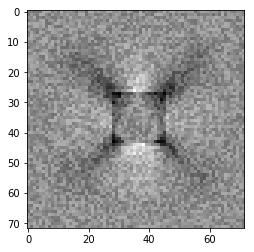

In [25]:
test_img_0=matrix_clf[:,0]
test_img_1=matrix_clf[:,1]
test_img_2=matrix_clf[:,2]

plt.imshow(test_img_0.reshape(72,72), cmap='gray')

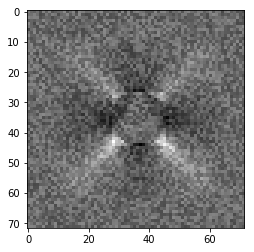

In [26]:
plt.imshow(test_img_1.reshape(72,72), cmap='gray')

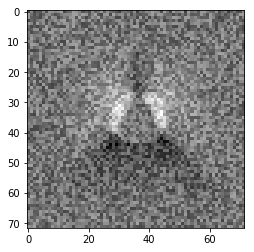

In [27]:
plt.imshow(test_img_2.reshape(72,72), cmap='gray')

# Question 4. Classification

In [28]:
[X_train_4, Y_train_4] = generate_dataset_classification(300, 20, True)
[X_test_4, Y_test_4] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [29]:
rows, cols = 72, 72 # save img shape
pooling_shape = (2, 2) # Pool size
kernel_size = (5, 5) # convolution kernel size
nb_filters = 16 
input_shape = (rows, cols, 1) 

possible_classes=3

In [30]:
X_train_4 = X_train_4.reshape(X_train_4.shape[0], rows, cols, 1)
X_test_4 = X_test_4.reshape(X_test_4.shape[0], rows, cols, 1)

Y_train_4 = np_utils.to_categorical(Y_train_4, possible_classes)
#Y_test_4 = np_utils.to_categorical(Y_test_4, possible_classes)

In [31]:
Y_train_4.shape #to check

(300, 3)

Fitting model

In [32]:
model_4=Sequential()

model_4.add(Conv2D(16,
              kernel_size[0], kernel_size[1], 
              input_shape=(72, 72, 1),
              activation='relu'))
print(model_4.output_shape)

(None, 68, 68, 16)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (5, 5), input_shape=(72, 72, 1..., activation="relu")`
  


In [33]:
model_4.add(MaxPooling2D(pooling_shape))
print(model_4.output_shape)

(None, 34, 34, 16)


In [34]:
model_4.add(Flatten())
print(model_4.output_shape)

(None, 18496)


In [35]:
model_4.add(Dense(256,activation=('relu')))
model_4.add(Dense(3,activation=('softmax')))
print(model_4.output_shape)

(None, 3)


In [36]:
adam=keras.optimizers.adam()

model_4.compile(optimizer=adam,
               loss='categorical_crossentropy',
               metrics=['accuracy'])

In [37]:
batch_size_2 =32
nb_epoch_2 = 20
model_Q4_adam = model_4.fit(X_train_4, 
                     Y_train_4,
                     batch_size=batch_size_2, 
                     validation_split=0.3,
                     epochs=nb_epoch_2)

Train on 210 samples, validate on 90 samples
Epoch 1/20
210/210 [==============================] - 2s 9ms/step - loss: 2.6191 - acc: 0.3524 - val_loss: 1.2990 - val_acc: 0.2778
Epoch 2/20
210/210 [==============================] - 1s 7ms/step - loss: 1.1411 - acc: 0.4429 - val_loss: 0.9977 - val_acc: 0.4889
Epoch 3/20
210/210 [==============================] - 1s 7ms/step - loss: 0.8812 - acc: 0.7810 - val_loss: 0.9403 - val_acc: 0.6667
Epoch 4/20
210/210 [==============================] - 2s 8ms/step - loss: 0.7113 - acc: 0.8381 - val_loss: 0.9106 - val_acc: 0.6333
Epoch 5/20
210/210 [==============================] - 2s 7ms/step - loss: 0.5871 - acc: 0.8333 - val_loss: 0.8379 - val_acc: 0.7222
Epoch 6/20
210/210 [==============================] - 1s 7ms/step - loss: 0.4549 - acc: 0.8810 - val_loss: 0.8908 - val_acc: 0.6667
Epoch 7/20
210/210 [==============================] - 1s 7ms/step - loss: 0.3524 - acc: 0.9190 - val_loss: 0.8014 - val_acc: 0.6222
Epoch 8/20
210/210 [===========

In [38]:
score = model_4.evaluate(X_test_4, Y_test_4)

300/300 [==============================] - 1s 2ms/step


In [39]:
print(score)

[1.0096702496210734, 0.69666666666666666]


# Question 5. Regression Problem

In [40]:
[X_train_5, Y_train_5] = generate_dataset_regression(3000, 20)
[X_test_5, Y_test_5] = generate_test_set_regression()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2

In [41]:
def sort_by_norm(T):
    p =[[T[0], T[1], np.sqrt(T[0]**2 + T[1]**2)], #norm2
        [T[2], T[3], np.sqrt(T[2]**2 + T[3]**2)],
        [T[4], T[5], np.sqrt(T[4]**2 + T[5]**2)]]
    p.sort(key=lambda x:x[2])
    sorted_T = np.array([p[0][0], p[0][1], p[1][0], p[1][1], p[2][0], p[2][1]])
    return sorted_T

In [42]:
for i in range(X_train_5.shape[0]):
    Y_train_5[i] = sort_by_norm(Y_train_5[i])
for i in range(X_test_5.shape[0]):
    Y_test_5[i] = sort_by_norm(Y_test_5[i])
    
X_train_5 = X_train_5.reshape(X_train_5.shape[0], 72, 72, 1)
X_test_5 = X_test_5.reshape(X_test_5.shape[0], 72, 72, 1)

In [43]:
model = Sequential()

model.add(Conv2D(filters=32, activation='relu', input_shape=(72, 72, 1), kernel_size=(3, 3),
padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
model.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(6))

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.fit(X_train_5, Y_train_5, epochs=10, batch_size=32, validation_data=(X_test_5, Y_test_5))

Train on 3000 samples, validate on 300 samples
Epoch 1/10
3000/3000 [==============================] - 29s 10ms/step - loss: 0.0508 - acc: 0.5797 - val_loss: 0.0276 - val_acc: 0.7333
Epoch 2/10
3000/3000 [==============================] - 26s 9ms/step - loss: 0.0211 - acc: 0.7423 - val_loss: 0.0190 - val_acc: 0.7067
Epoch 3/10
3000/3000 [==============================] - 26s 9ms/step - loss: 0.0139 - acc: 0.7950 - val_loss: 0.0159 - val_acc: 0.7867
Epoch 4/10
3000/3000 [==============================] - 26s 9ms/step - loss: 0.0103 - acc: 0.8037 - val_loss: 0.0136 - val_acc: 0.7567
Epoch 5/10
3000/3000 [==============================] - 26s 9ms/step - loss: 0.0080 - acc: 0.8190 - val_loss: 0.0144 - val_acc: 0.7533
Epoch 6/10
3000/3000 [==============================] - 29s 10ms/step - loss: 0.0063 - acc: 0.8237 - val_loss: 0.0127 - val_acc: 0.8100
Epoch 7/10
3000/3000 [==============================] - 27s 9ms/step - loss: 0.0050 - acc: 0.8367 - val_loss: 0.0124 - val_acc: 0.7867
Epoch 

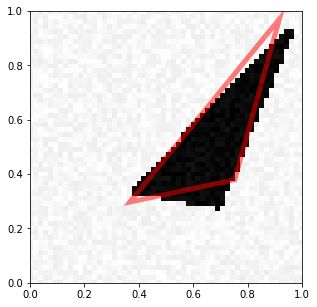

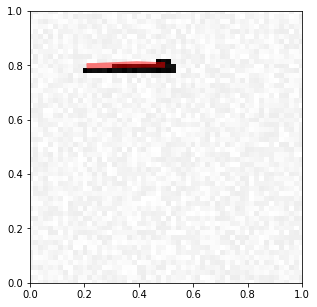

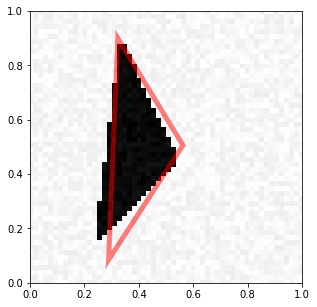

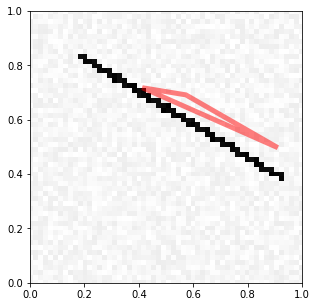

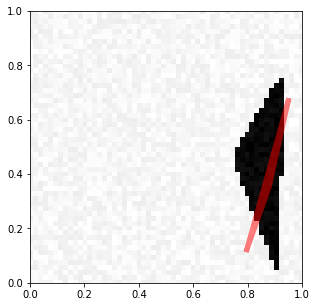

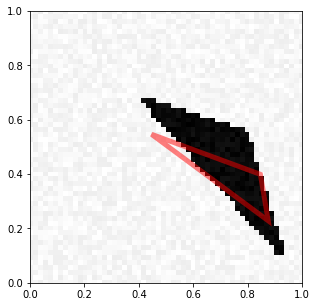

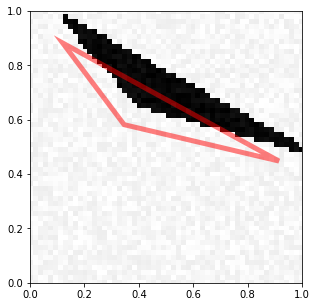

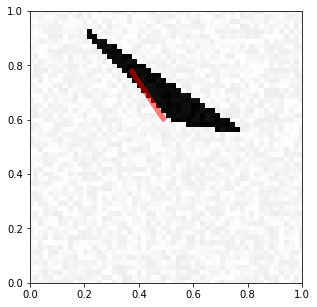

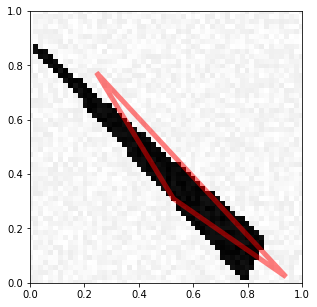

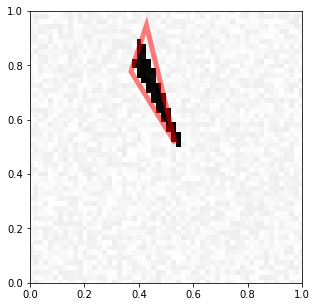

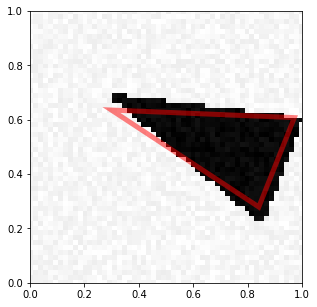

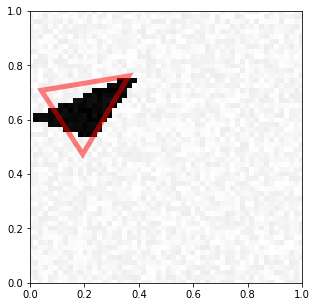

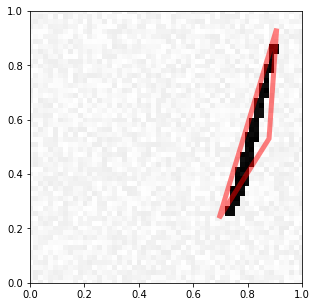

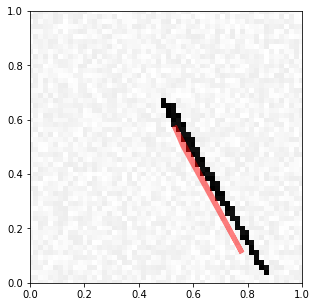

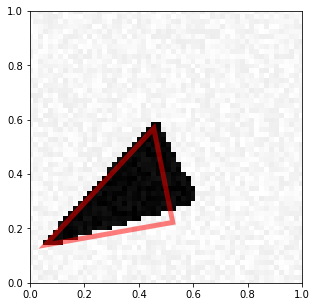

In [44]:
Y_pred_5 = model.predict(X_test_5, batch_size=32)

for i in range(15):
    visualize_prediction(X_test_5[i], Y_pred_5[i])

# BONUS (Not finished)

In [55]:
def generate_dataset_bonus(nb_samples, noise=0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X1 = np.zeros([nb_samples,im_size])
    X2 = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X1[i] = generate_a_rectangle(0.5, free_location)
            X2[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X1[i] = generate_a_disk(0.5, free_location)
            X2[i] = generate_a_disk(noise, free_location)
        else:
            [X1[i], V] = generate_a_triangle(0.5, free_location)
            [X2[i], V] = generate_a_triangle(noise, free_location)

    X1 = (X1 + noise) / (255 + 2 * noise)
    X2 = (X2 + noise) / (255 + 2 * noise)
    return [X1, X2]

def generate_test_set_bonus():
    np.random.seed(42)
    [X_test_noise, X_test_clean] = generate_dataset_bonus(300, 20, True)
    #Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test_noise, X_test_clean]


In [56]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Activation
from keras.models import Model
#Generating data
[X_train_noise, X_train_clean] = generate_dataset_bonus(1000, True)
[X_test_noise, X_test_clean] = generate_test_set_bonus()


#Transforming the data
X_train_clean = X_train_clean.reshape(len(X_train_clean), 72, 72, 1)
X_train_noise = X_train_noise.reshape(len(X_train_noise), 72, 72, 1)
X_test_clean = X_test_clean.reshape(len(X_test_clean), 72, 72, 1)
X_test_noise = X_test_noise.reshape(len(X_test_noise), 72, 72, 1)


Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [57]:
img = Input(shape=(72, 72, 1))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

Encode = MaxPooling2D((2, 2), padding='same')(x)


x = Conv2D(32, (3, 3), activation='relu', padding='same')(Encode)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)


Decode = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

In [58]:
autoencoder = Model(img, Decode)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(X_train_noise, X_train_clean, epochs=5, batch_size=32,
shuffle=True, validation_data=(X_test_noise, X_test_clean))

Train on 1000 samples, validate on 300 samples
Epoch 1/5
1000/1000 [==============================] - 28s 28ms/step - loss: 0.4367 - val_loss: 0.3881
Epoch 2/5
1000/1000 [==============================] - 25s 25ms/step - loss: 0.3404 - val_loss: 0.3595
Epoch 3/5
1000/1000 [==============================] - 25s 25ms/step - loss: 0.3020 - val_loss: 0.3580
Epoch 4/5
1000/1000 [==============================] - 26s 26ms/step - loss: 0.2863 - val_loss: 0.3738
Epoch 5/5
1000/1000 [==============================] - 28s 28ms/step - loss: 0.2843 - val_loss: 0.3751


In [59]:
X_pred_clean = autoencoder.predict(X_test_noise, batch_size=32)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


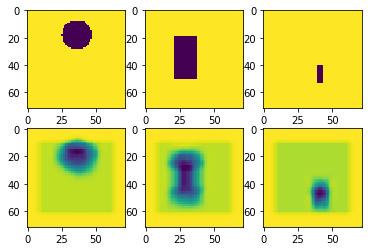

In [62]:
n=3
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test_clean[i].reshape(72, 72))
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test_noise[i].reshape(72, 72))
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(X_pred_clean[i].reshape(72, 72))
plt.show()